In [1]:
%pylab inline

import numpy as np
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
# Data generation
X0 = np.linspace(0, 10, 100)[:,None]
y0 = X0**(0.5) + np.exp(-X0/5)*np.sin(10*X0)
y0 += 0.1*np.random.normal(size=y0.shape)
y0 = np.squeeze(y0)

# y1
X1 = np.linspace(0, 15, 200)[:,None]
y1 = X1**(0.5) + np.exp(-X1/6)*np.sin(8*X1)
y1 = np.squeeze(y1)

with pm.Model() as model:
    l = pm.HalfNormal('l',5.)
    cov_func = pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y0_ = gp.marginal_likelihood('y0',X0,y0,0.1)
    tr = pm.sample(1000)  # faster if you're using multithreaded blas

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [l_log__]
INFO:pymc3:NUTS: [l_log__]
100%|██████████| 1500/1500 [01:31<00:00, 16.34it/s]


In [23]:
import theano
ynew = theano.shared(y1)
with model:
    y1_ = gp.conditional('y1', X1)
    logp = pm.Deterministic('logp', y1_.distribution.logp(ynew))

In [24]:
with model: 
    ppc = pm.sample_ppc(tr, 100, vars=[y1_])

100%|██████████| 100/100 [00:02<00:00, 40.08it/s]


In [33]:
logp_val, y1_sample = pm.distributions.draw_values([logp, y1_], tr[999])

In [34]:
logp_val

array(-9584870.99062065)

In [35]:
point = tr[999] # get a point from trace
point['y1'] = y1
y1_.logp(point)

array(-9584870.99062065)

https://discourse.pymc.io/t/posterior-sample-from-an-approximation-with-minibatches/824/9

In [2]:
n_subjects = int(1e3)
n_obs = 200
cov = 2. * pm.gp.cov.RatQuad(1, 0.2, 0.1)
X = np.linspace(0, 2, n_obs)[:,None]
K = cov(X).eval()

fulldata = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=n_subjects) + \
           pm.Normal.dist(2, 3).random(size=(n_subjects,1))
batches = pm.Minibatch(fulldata, 50) 

In [3]:
fulldata.shape

(1000, 200)

In [10]:
np.mean(fulldata)

2.147733603162256

In [4]:
with pm.Model():
    # an informed prior
    mu = pm.Normal('shiftmu', np.mean(fulldata), 10)
    sigma = pm.HalfCauchy('sigma', 2.5)
    cov = 2. * pm.gp.cov.RatQuad(1, 0.2, 0.1)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=X)
    shifts = pm.Deterministic('shifts', tt.mean(batches-f.T, axis=0))
    pm.Normal('infer', mu, sigma, observed = shifts, total_size= n_subjects)
    approximation = pm.fit()

Average Loss = 1,465.8: 100%|██████████| 10000/10000 [00:12<00:00, 820.56it/s]
Finished [100%]: Average Loss = 1,463.2


In [6]:
sample_shifts = approximation.sample_node(shifts,  more_replacements={batches: fulldata[:128,:]}, size=100)
posteriorshifts = sample_shifts.eval()

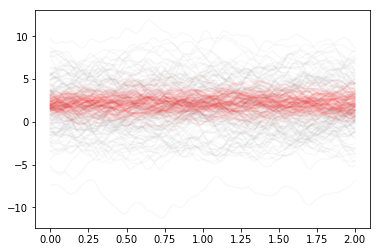

In [9]:
plt.plot(X, fulldata[:128,:].T, color='gray', alpha=.05);
plt.plot(X, posteriorshifts.T, color='red', alpha=.05);

In [11]:
batches.eval().shape

(50, 200)

In [12]:
f.tag.test_value.shape

(200,)

In [13]:
shifts.tag.test_value.shape

(200,)

In [14]:
posteriorshifts.shape

(100, 200)

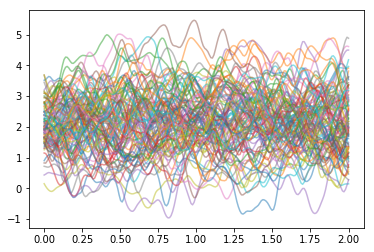

In [15]:
plt.plot(X, posteriorshifts.T, alpha=.5);

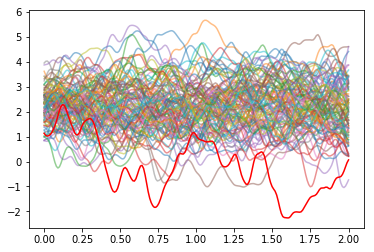

In [18]:
sample_shifts = approximation.sample_node(shifts,  more_replacements={batches: fulldata[10,:]}, size=100)
posteriorshifts = sample_shifts.eval()
plt.plot(X, posteriorshifts.T, alpha=.5);
plt.plot(X, fulldata[10,:], color='r');

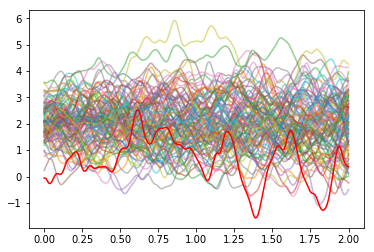

In [17]:
sel = np.random.randint(n_subjects)
sample_shifts = approximation.sample_node(shifts,  more_replacements={batches: fulldata[sel,:]}, size=100)
posteriorshifts = sample_shifts.eval()
plt.plot(X, posteriorshifts.T, alpha=.5);
plt.plot(X, fulldata[sel,:], color='r');

In [23]:
with pm.Model() as m:
    # an informed prior
    mu = pm.Normal('shiftmu', np.mean(fulldata), 10)
    sigma = pm.HalfCauchy('sigma', 2.5)
    cov = 2. * pm.gp.cov.RatQuad(1, 0.2, 0.1)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=X)
    pm.Normal('infer', mu-f.T, sigma, observed=batches, total_size = (n_subjects, n_obs))
    approximation = pm.ADVI()

In [21]:
approximation.fit(100000)

Average Loss = 5.213e+05: 100%|██████████| 100000/100000 [03:05<00:00, 539.19it/s]
Finished [100%]: Average Loss = 5.2134e+05
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 5.2134e+05


In [35]:
trace = approximation.approx.sample(10)

In [36]:
ppc = pm.sample_ppc(trace, model=m)

100%|██████████| 10/10 [00:00<00:00, 522.39it/s]


In [37]:
ppc['infer'].shape

(10, 200)

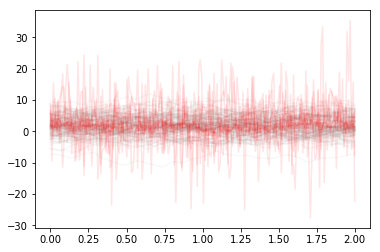

In [39]:
plt.plot(X, fulldata[:128,:].T, color='gray', alpha=.05);
plt.plot(X, ppc['infer'][:128,:].T, color='red', alpha=.1);